In [57]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


In [58]:
import pandas as pd
import numpy as np
import csv

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 100

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
#Data = pd.read_csv('/content/gdrive/MyDrive/Data/new_tweets.csv')
Data = pd.read_csv('/content/gdrive/MyDrive/Data/Merge_Dataset.csv')
Data.head()

,text,lable
0,i didnt feel humiliated,negative
1,i can go from feeling so hopeless to so damned...,negative
2,im grabbing a minute to post i feel greedy wrong,negative
3,i am ever feeling nostalgic about the fireplac...,positive
4,i am feeling grouchy,negative


In [61]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(Data.text)

In [62]:
tokenizer.texts_to_sequences([Data.text[0]])

[[2, 166, 5, 833]]

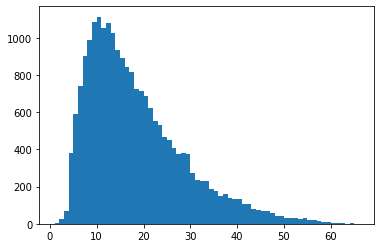

In [63]:
lengths = [len(t.split(' ')) for t in Data.text]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [64]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [65]:
padded_train_seq = get_sequences(tokenizer, Data.text)

In [66]:
padded_train_seq[0]

array([  2, 166,   5, 833,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [67]:
classes = set(Data.lable)
print(classes)

{'positive', 'neutral', 'negative'}


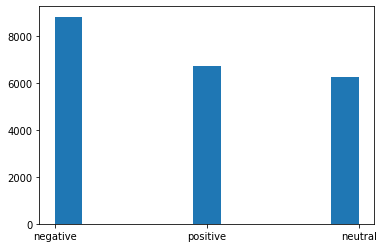

In [68]:
plt.hist(Data.lable, bins=11)
plt.show()

In [69]:
class_to_index = dict((c, i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [70]:
class_to_index

{'negative': 2, 'neutral': 1, 'positive': 0}

In [71]:
index_to_class

{0: 'positive', 1: 'neutral', 2: 'negative'}

In [72]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in Data.lable])

In [73]:
train_labels = names_to_ids(Data.lable)
print(train_labels[3])

0


In [74]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [75]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(Data, test_size=0.2)

train=Data.sample(frac=0.8,random_state=200) #random state is a seed value
test=Data.drop(train.index)
len(train.lable)

17426

In [76]:
names_to_train_ids = lambda labels: np.array([class_to_index.get(x) for x in train.lable])

In [79]:
train_tweets, train_label = train.text, train.lable
train_seq = get_sequences(tokenizer, train_tweets)
train_label = names_to_train_ids(train_label)
#print(train_tweets[4])

In [80]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(train_seq, train_label),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
681/681 [==============================] - 98s 136ms/step - loss: 0.6366 - accuracy: 0.7029 - val_loss: 0.2472 - val_accuracy: 0.9231
Epoch 2/20
681/681 [==============================] - 92s 134ms/step - loss: 0.1993 - accuracy: 0.9394 - val_loss: 0.1321 - val_accuracy: 0.9610
Epoch 3/20
681/681 [==============================] - 92s 136ms/step - loss: 0.1126 - accuracy: 0.9666 - val_loss: 0.0771 - val_accuracy: 0.9763
Epoch 4/20
681/681 [==============================] - 92s 135ms/step - loss: 0.0635 - accuracy: 0.9822 - val_loss: 0.0435 - val_accuracy: 0.9869
Epoch 5/20
681/681 [==============================] - 91s 133ms/step - loss: 0.0425 - accuracy: 0.9882 - val_loss: 0.0283 - val_accuracy: 0.9927
Epoch 6/20
681/681 [==============================] - 91s 134ms/step - loss: 0.0314 - accuracy: 0.9914 - val_loss: 0.0227 - val_accuracy: 0.9947
Epoch 7/20
681/681 [==============================] - 92s 135ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 0.0239 - val_ac

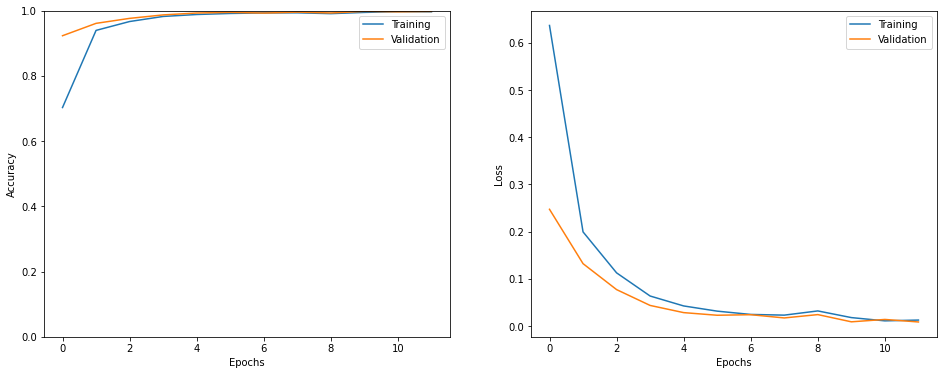

In [81]:
show_history(h)

In [82]:
names_to_test_ids = lambda labels: np.array([class_to_index.get(x) for x in test.lable])

In [83]:
test_tweets, test_labels = test.text,test.lable
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_test_ids(test_labels)

In [84]:
_ = model.evaluate(test_seq, test_labels)

137/137 [==============================] - 3s 24ms/step - loss: 0.0045 - accuracy: 0.9991


In [86]:
i = random.randint(0, len(test_labels) - 1)
print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i am still feeling passionate progressive and motivated but i am no longer trying to do everything and anything that i have never done before
Emotion:  negative
Predicted Emotion:  negative


In [87]:
sentence = ["having problem with the system, can I complain somewhere?", "I want to open a new account.","i am paying 1000"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
print(model.predict(padded))

[[0.003 0.586 0.411 0.    0.    0.   ]
 [0.991 0.003 0.006 0.    0.    0.   ]
 [0.094 0.557 0.349 0.    0.    0.   ]]


In [88]:
p = model.predict(padded)[1]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ', pred_class)
print(f'Test loss: {p[0]} / Test accuracy: {p[0]}')

Predicted Emotion:  positive
Test loss: 0.990872323513031 / Test accuracy: 0.990872323513031
